In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model

In [22]:
#Get data
file_path="data/cleaned_stock_data.csv"
df = pd.read_csv(
    file_path,
    na_values=['null'],
    index_col='DTYYYYMMDD',
    parse_dates=True,
    infer_datetime_format=True
    )

print("First few rows of dataset:")
print(df.head())

print("Dataset information:")
print(df.info())

First few rows of dataset:
           Ticker  Open   High    Low  Close   Volume
DTYYYYMMDD                                           
2021-06-25    BID  45.1  46.00  44.70  45.55  2572300
2021-06-24    BID  45.4  45.90  45.00  45.20  2110700
2021-06-23    BID  44.9  46.40  44.90  45.40  2574200
2021-06-22    BID  45.3  45.45  44.90  45.00  2781900
2021-06-21    BID  45.0  46.00  44.85  45.00  4237600
Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68913 entries, 2021-06-25 to 2017-11-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  68913 non-null  object 
 1   Open    68913 non-null  float64
 2   High    68913 non-null  float64
 3   Low     68913 non-null  float64
 4   Close   68913 non-null  float64
 5   Volume  68913 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.7+ MB
None


C:\Users\Khai Cao\AppData\Local\Temp\ipykernel_5708\4025158043.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


In [23]:
#print the shape of dataframe and check for the null values
print("Dataframe Shape: ",df.shape)
print("Null Values Present: ", df.isnull().values.any())

Dataframe Shape:  (68913, 6)
Null Values Present:  False


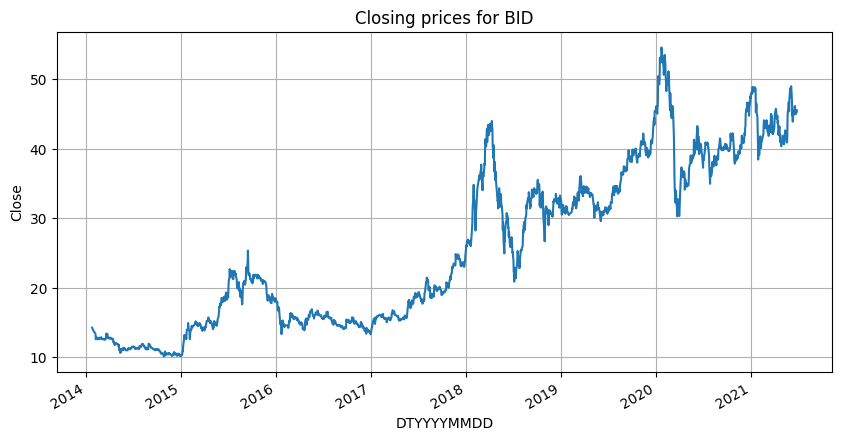

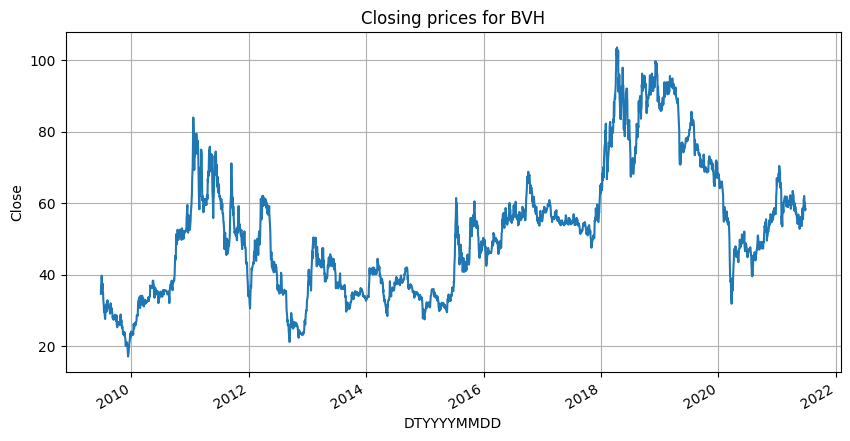

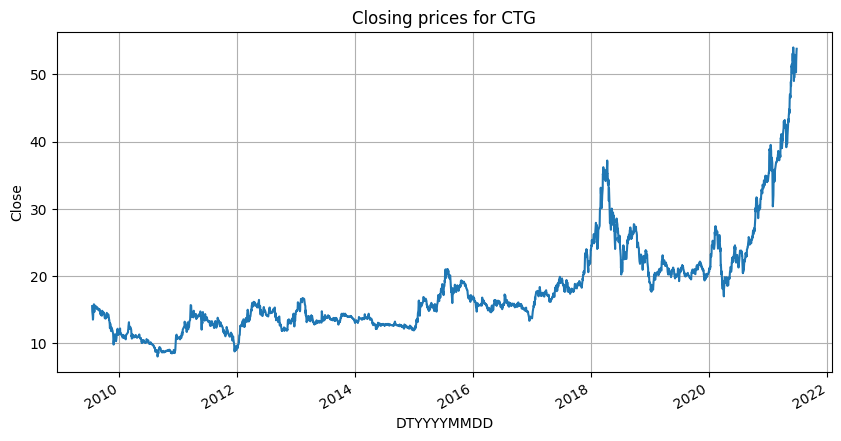

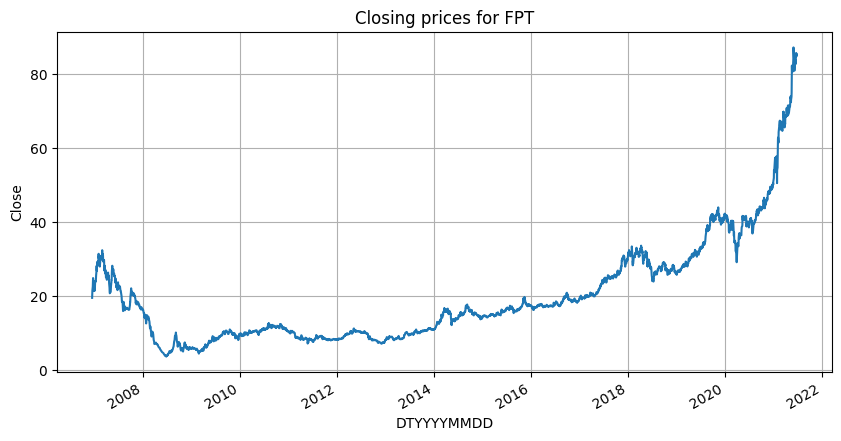

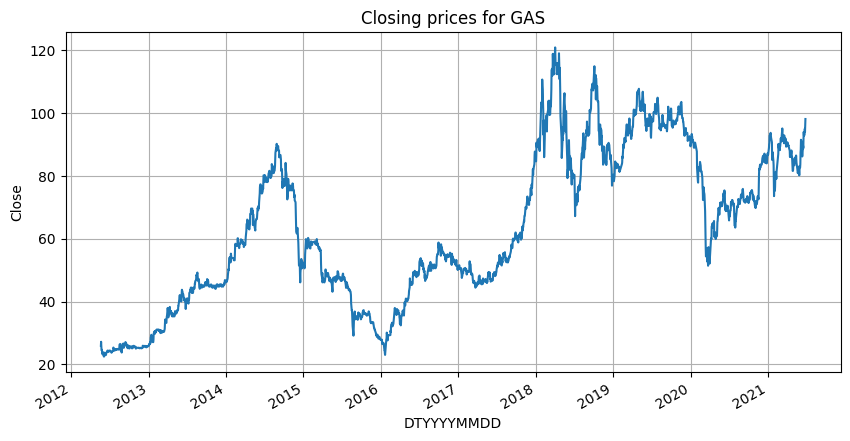

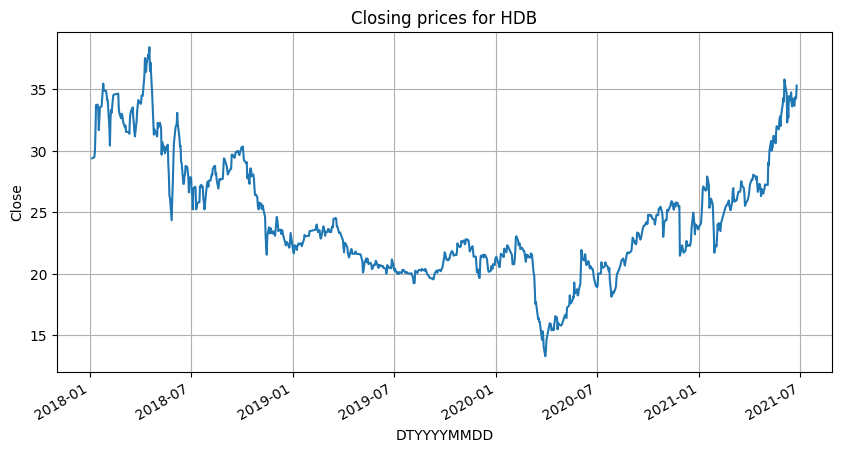

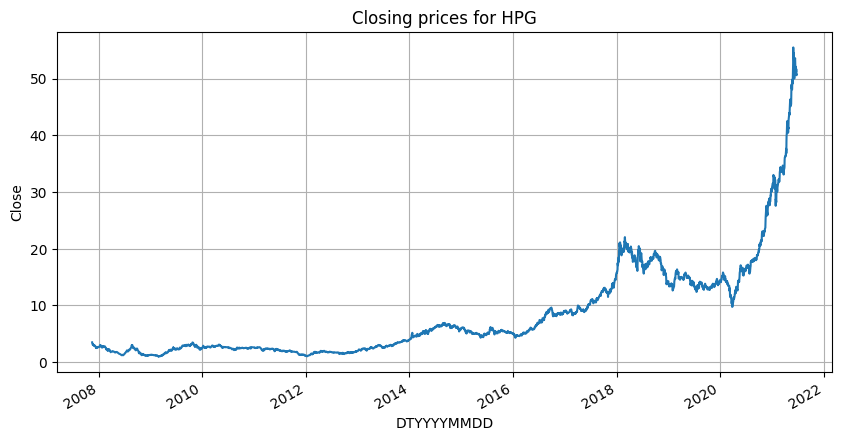

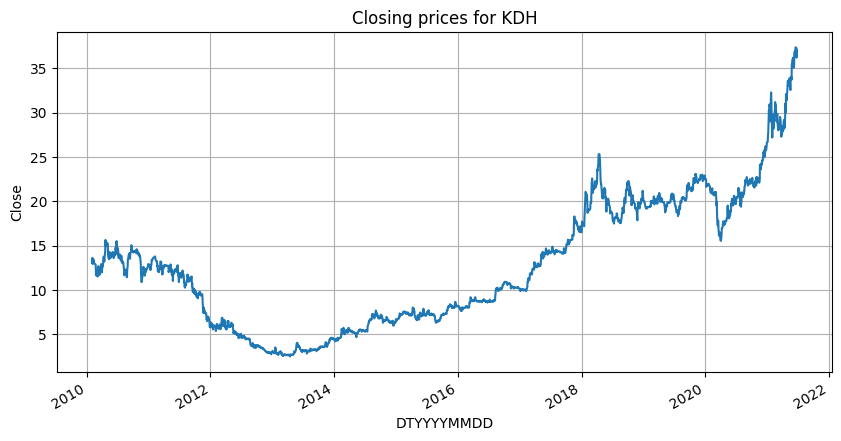

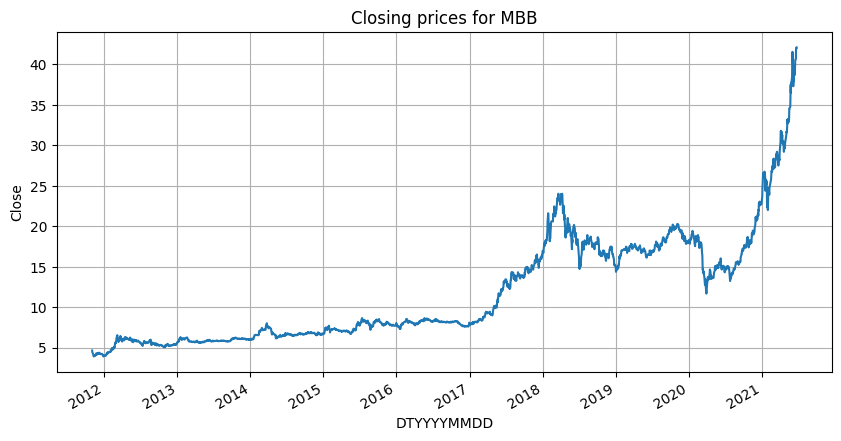

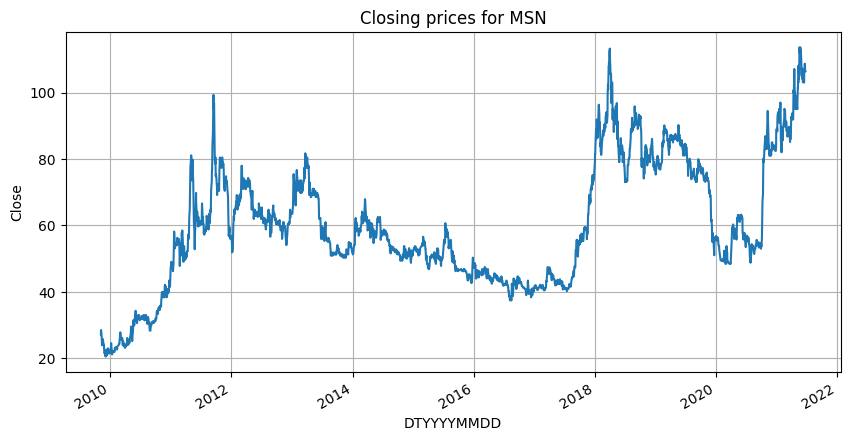

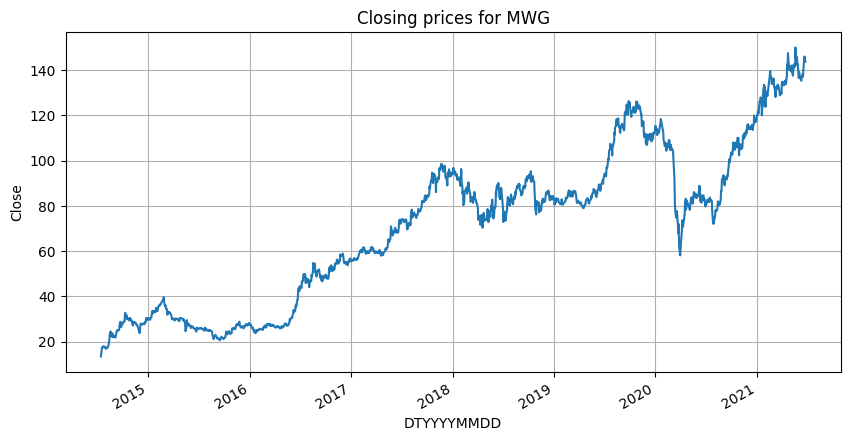

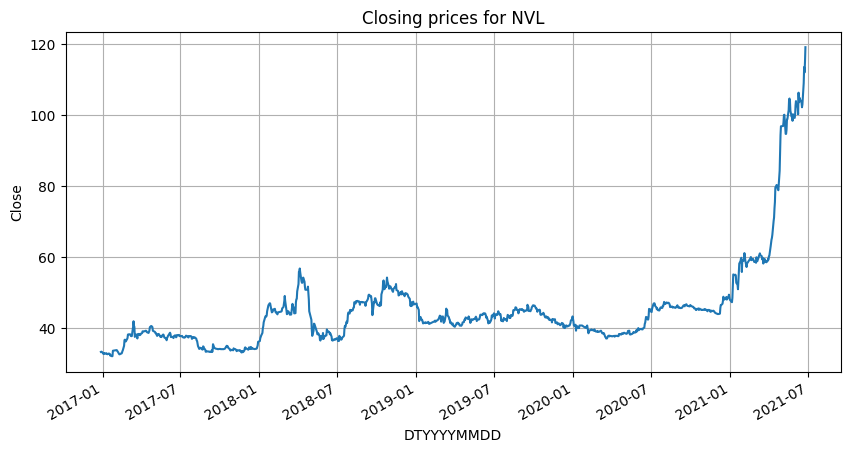

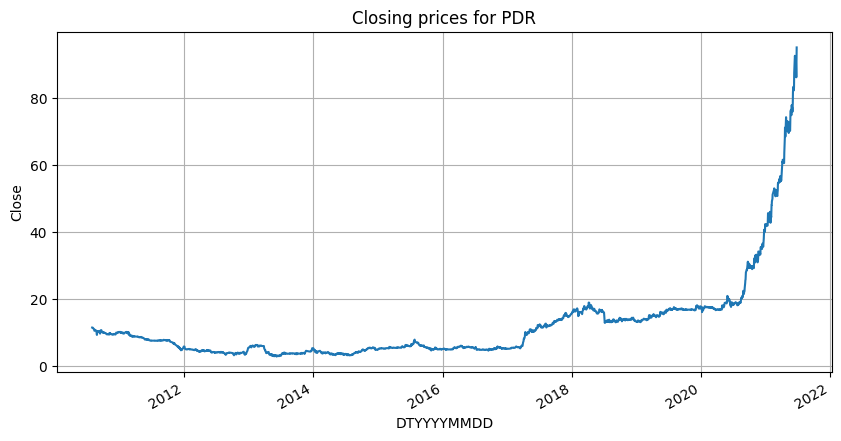

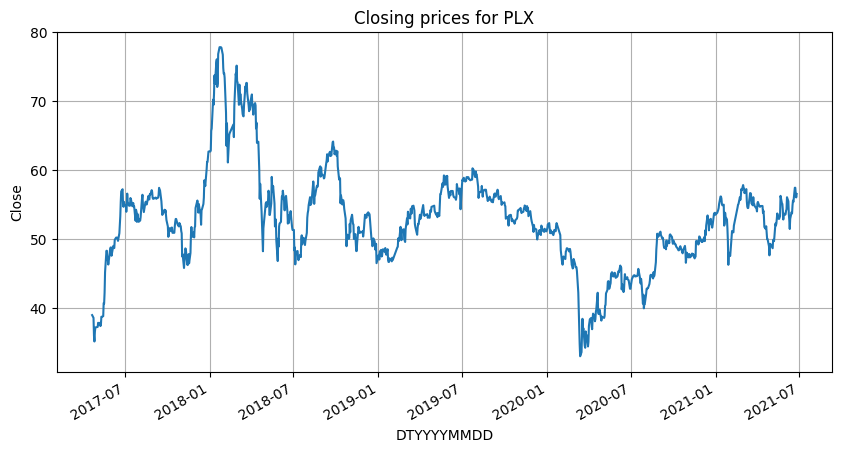

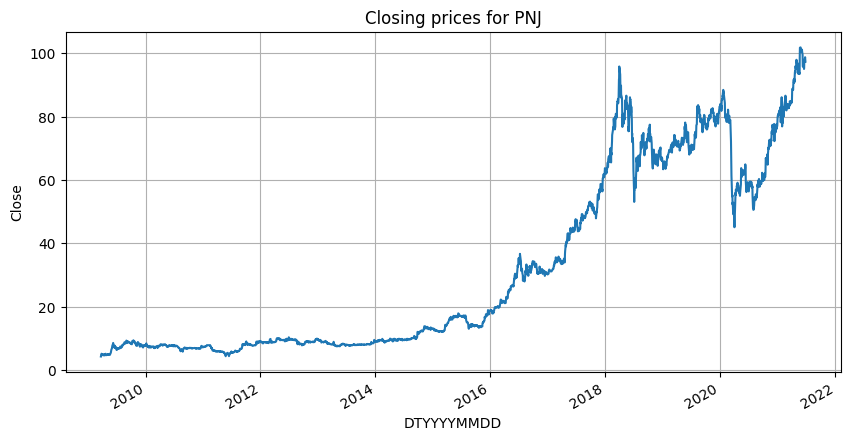

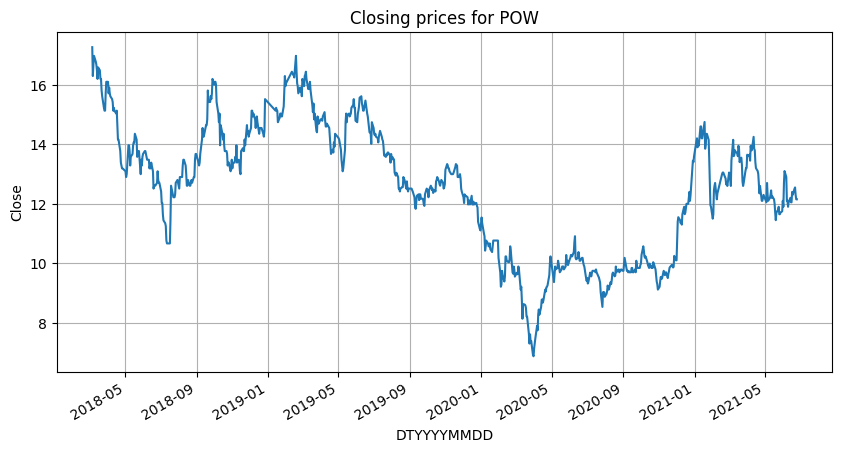

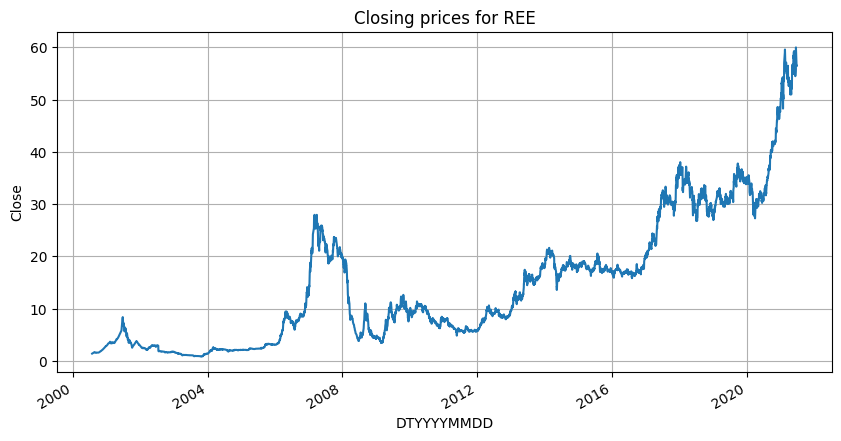

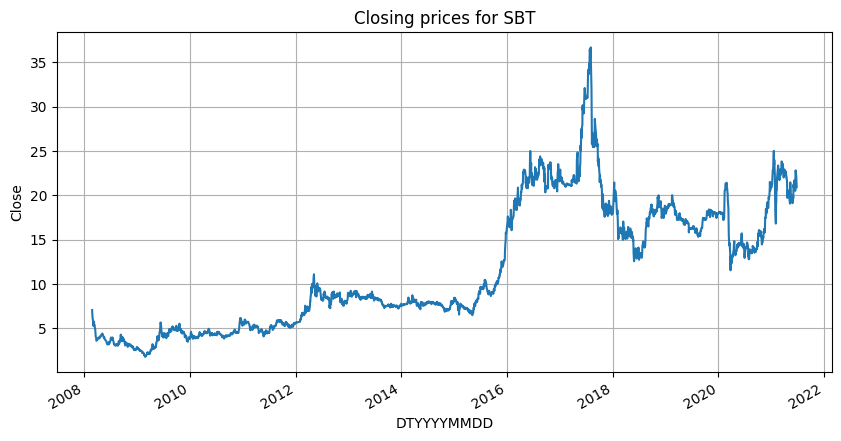

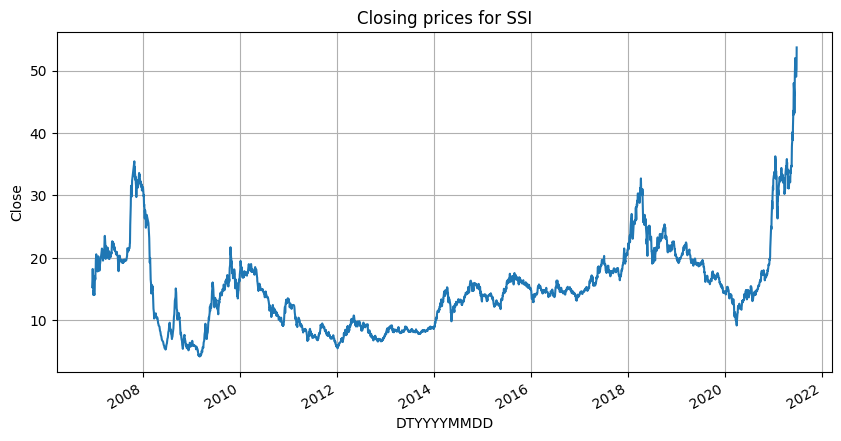

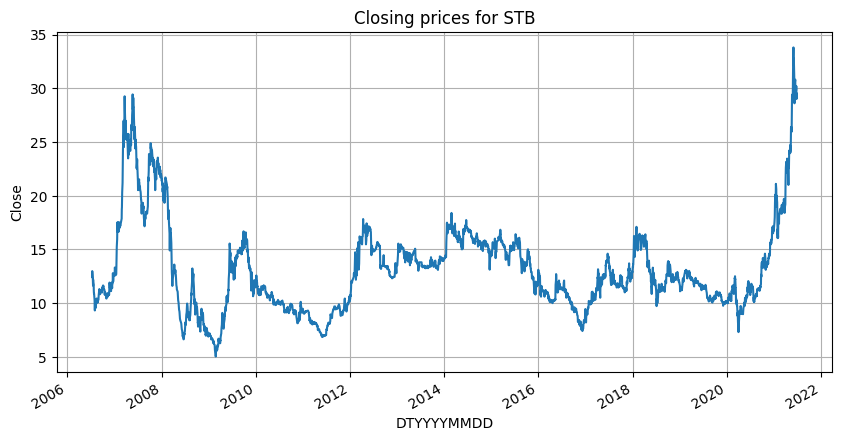

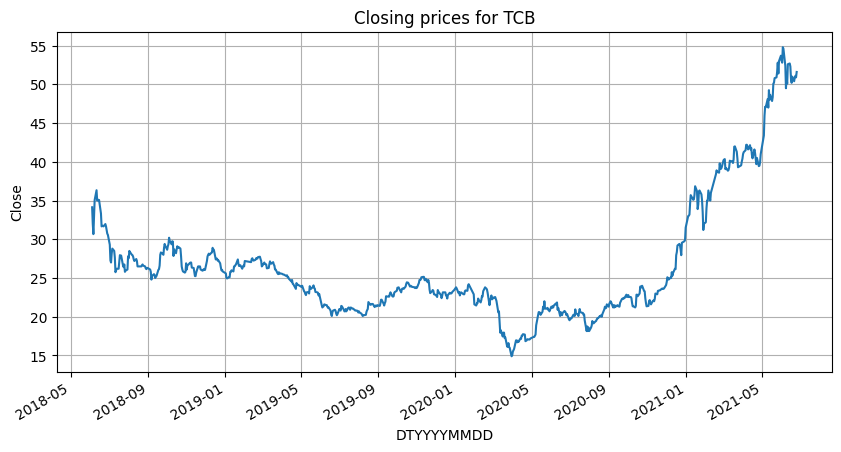

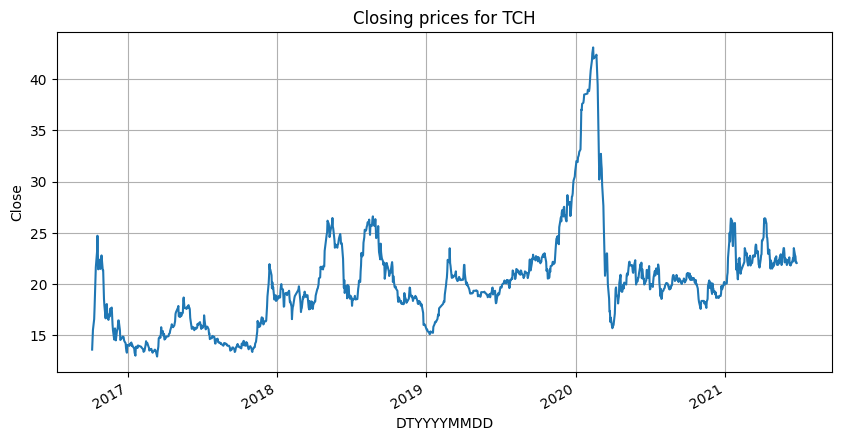

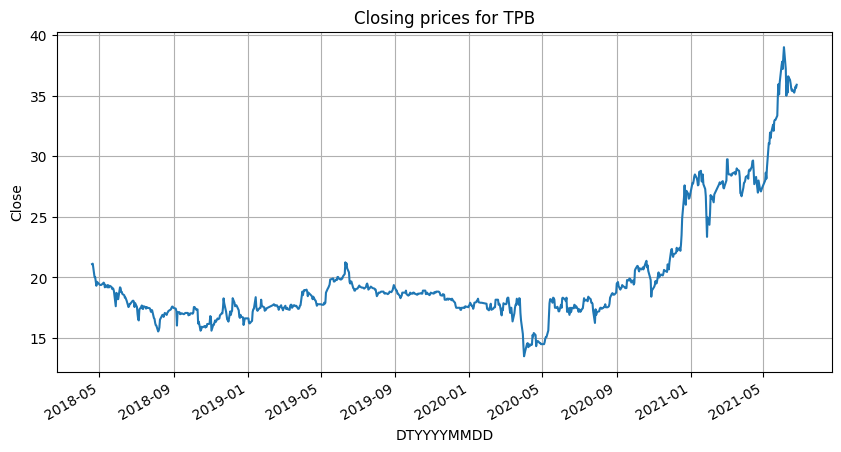

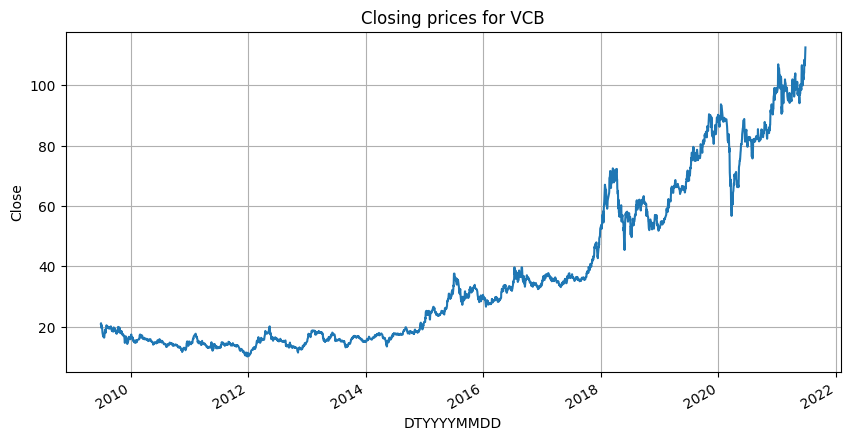

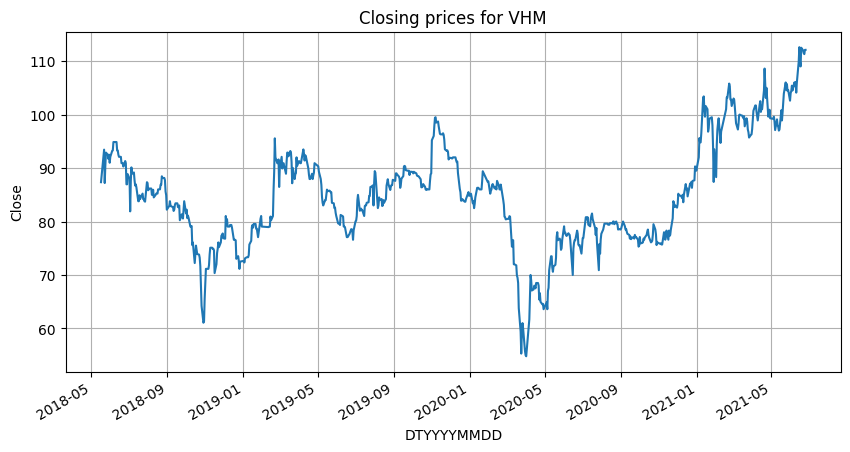

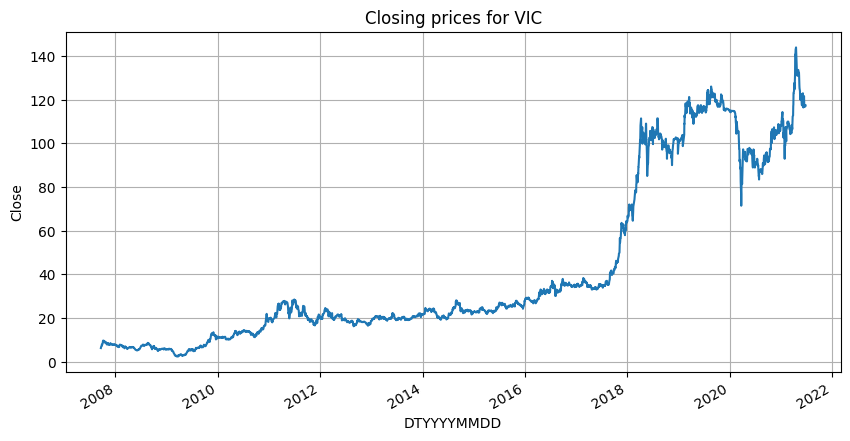

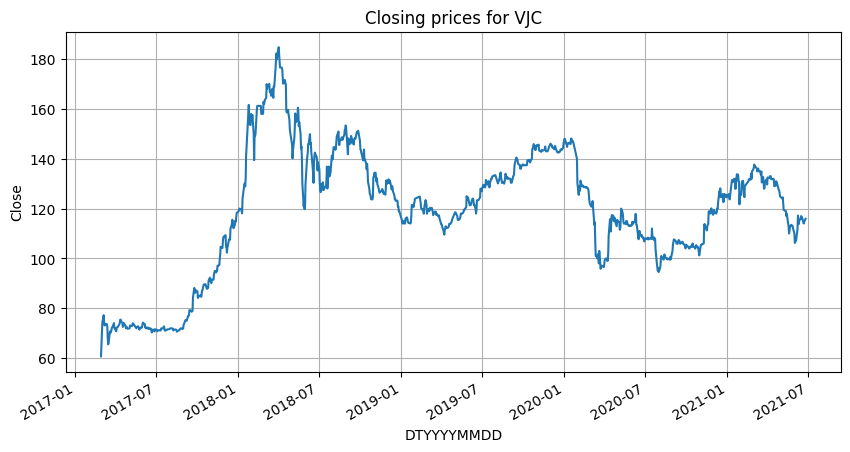

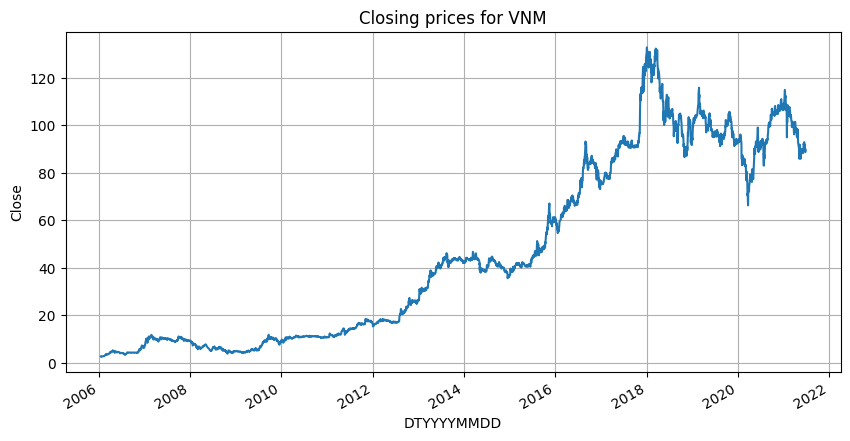

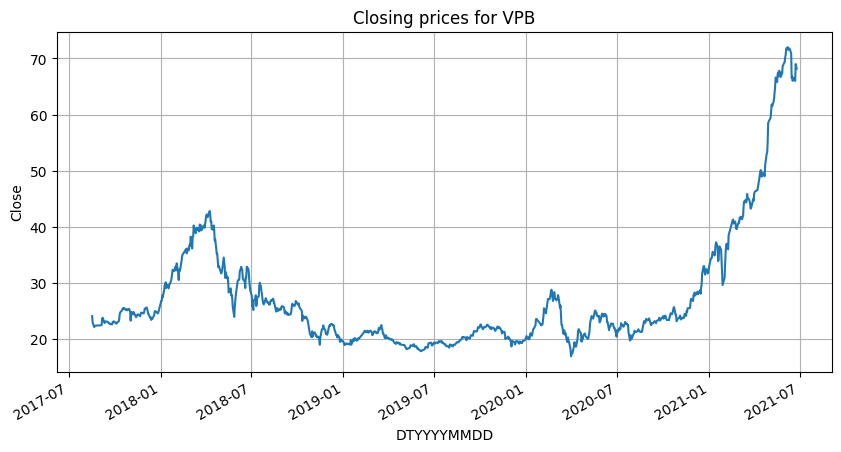

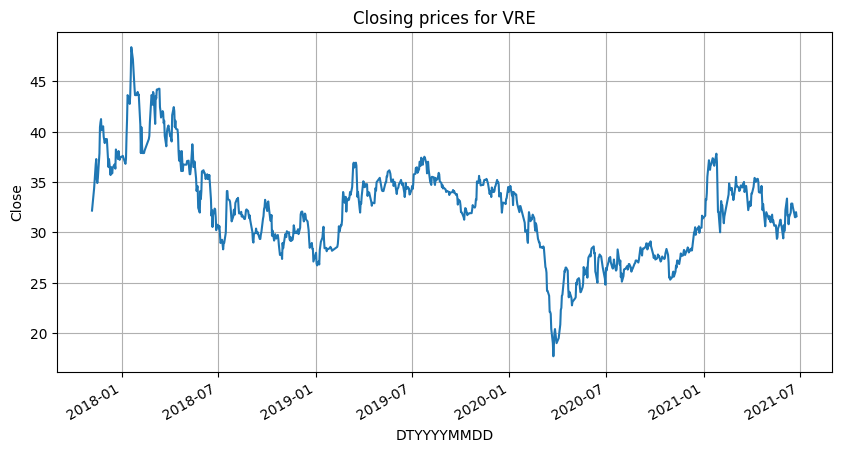

In [24]:
#Group the data by Ticker
grouped = df.groupby('Ticker')

#plot 'Close' values for each 'Ticker'
for ticker, data in grouped:
    plt.figure(figsize=(10,5)) #set figure size for each plot
    data['Close'].plot(title=f"Closing prices for {ticker}")
    plt.xlabel("DTYYYYMMDD")
    plt.ylabel("Close")
    plt.grid()
    plt.show()

In [25]:
#set target variable
output_var = pd.DataFrame(df['Close'])
#selecting features
features= ['Open', 'High', 'Low','Volume']

In [26]:
#Scaling
scaler = MinMaxScaler()
scaled_data = pd.DataFrame()

for ticker, data in df.groupby('Ticker'):
    
    feature_transform = scaler.fit_transform(df[features])
    #conver the scaled features back into a dataframe
    scaled_company_data = pd.DataFrame(
        data = feature_transform,
        columns=features,
        index=df.index
    )
    #add the 'Ticker' column back to the scaled data
    scaled_company_data['Ticker'] = ticker
    #append the scaled dta to final dataframe
    scaled_data = pd.concat([scaled_data, scaled_company_data])
    
print("Scaled data (first few rows):")
print(scaled_data.head())

Scaled data (first few rows):
                Open      High       Low    Volume Ticker
DTYYYYMMDD                                               
2021-06-25  0.244014  0.243986  0.246018  0.025728    BID
2021-06-24  0.245637  0.243445  0.247670  0.021111    BID
2021-06-23  0.242932  0.246147  0.247119  0.025747    BID
2021-06-22  0.245096  0.241013  0.247119  0.027825    BID
2021-06-21  0.243473  0.243986  0.246844  0.042385    BID


In [27]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Assuming 'df' is your dataset and 'Ticker' is the column with ticker symbols
timesplit = TimeSeriesSplit(n_splits=10)

# Set target variable - 'Close' column
output_var = 'Close'  # Using 'Close' directly for simplicity

# Features selection - 'Open', 'High', 'Low', 'Volume'
features = ['Open', 'High', 'Low', 'Volume']

# Sort the DataFrame by Ticker and DTYYYYMMDD to maintain the time order
df = df.sort_values(by=['Ticker', 'DTYYYYMMDD'])

# Initialize empty lists to store the train and test data for each split
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Perform time series split on the entire dataset
for train_index, test_index in timesplit.split(df):
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]
    
    # Split the features and the target for each of the train and test sets
    X_train = train_data[features]
    X_test = test_data[features]
    
    # Ensure that the output variable is present and process it
    y_train = train_data[output_var].dropna().values.ravel()  # Drop NaNs if any
    y_test = test_data[output_var].dropna().values.ravel()    # Drop NaNs if any

    # Store the data for this split
    X_train_all.append(X_train)
    X_test_all.append(X_test)
    y_train_all.append(y_train)
    y_test_all.append(y_test)
    
# Convert lists to NumPy arrays
X_train_all = np.concatenate(X_train_all, axis=0)  # Concatenate all training data
X_test_all = np.concatenate(X_test_all, axis=0)    # Concatenate all test data
y_train_all = np.concatenate(y_train_all, axis=0)  # Concatenate all target train data
y_test_all = np.concatenate(y_test_all, axis=0)    # Concatenate all target test data

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Group the data by Ticker
grouped = df.groupby('Ticker')

# Initialize empty lists to store the processed data for LSTM
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Perform time series split on the grouped data
timesplit = TimeSeriesSplit(n_splits=10)

for ticker, group in grouped:
    # Sort the group by DTYYYYMMDD to maintain the time order
    group = group.sort_values(by='DTYYYYMMDD')

    # Set target variable and select features for each ticker's data
    output_var = 'Close'  # 'Close' column as target variable
    features = ['Open', 'High', 'Low', 'Volume']  # List of features

    # Split the group into features and target variable
    X = group[features].values  # Features (Open, High, Low, Volume)
    y = group[output_var].values  # Target (Close)
    
    # Perform time series split for each ticker's group
    for train_index, test_index in timesplit.split(X):
        # Split the features and target for train and test sets
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        # Reshape the data for LSTM (samples, timesteps, features)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # Append the processed data for this ticker to the lists
        X_train_all.append(X_train)
        X_test_all.append(X_test)
        y_train_all.append(y_train)
        y_test_all.append(y_test)

# Convert lists to NumPy arrays
X_train_all = np.concatenate(X_train_all, axis=0)  # Concatenate all training data
X_test_all = np.concatenate(X_test_all, axis=0)    # Concatenate all test data
y_train_all = np.concatenate(y_train_all, axis=0)  # Concatenate all target train data
y_test_all = np.concatenate(y_test_all, axis=0)    # Concatenate all target test data

# Check the shapes of the processed data
print("X_train_all shape:", X_train_all.shape)  # Expected shape: (num_samples, 1, num_features)
print("X_test_all shape:", X_test_all.shape)    # Expected shape: (num_samples, 1, num_features)


X_train_all shape: (345435, 1, 4)
X_test_all shape: (62490, 1, 4)


In [31]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, X_train_all.shape[2]), activation='relu', return_sequences=False))
lstm.add(Dense(1))

#Compile the model
lstm.compile(loss='mean_squared_error', optimizer='adam')

#display the model summary
plot_model(lstm, show_shapes=True, show_layer_names=True)

#print the model summary to see its architechture
lstm.summary()

history = lstm.fit(X_train_all, y_train_all, epochs=100, batch_size=8, verbose=1, shuffle=False)


You must install pydot (`pip install pydot`) for `plot_model` to work.


C:\Users\Khai Cao\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,769 (18.63 KB)

 Trainable params: 4,769 (18.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 7403117.0000
Epoch 2/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 1136913.1250
Epoch 3/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 559940.1250
Epoch 4/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 1767070.2500
Epoch 5/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - loss: 1111260.1250
Epoch 6/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - loss: 427.8457
Epoch 7/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 2539.3665
Epoch 8/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step - loss: 419.5590
Epoch 9/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 441.8483
Epoch 10/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 499.9784
Epoch 11/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 249609.4062
Epoch 12/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 424.1377
Epoch 13/100
43180/43180 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - loss: 99121.2

In [35]:
#LSTM Prediction
y_pred_all = lstm.predict(X_test_all)

1953/1953 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


1953/1953 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


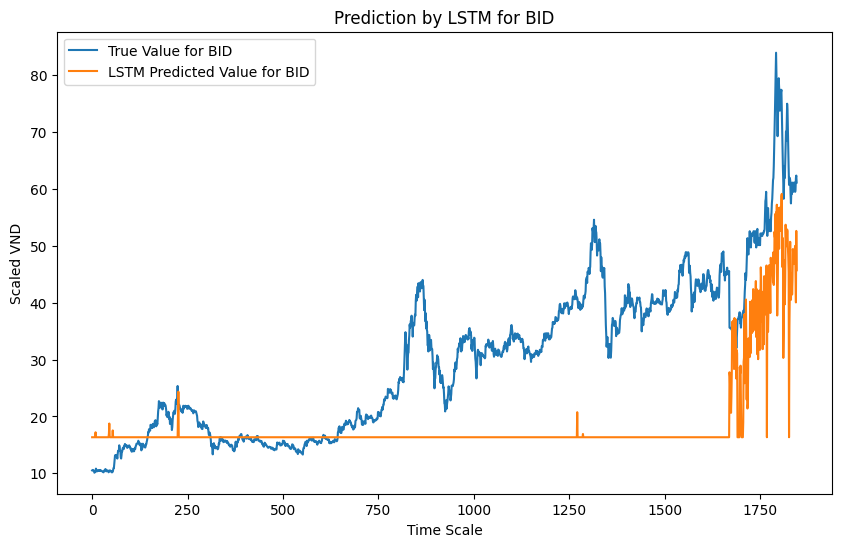

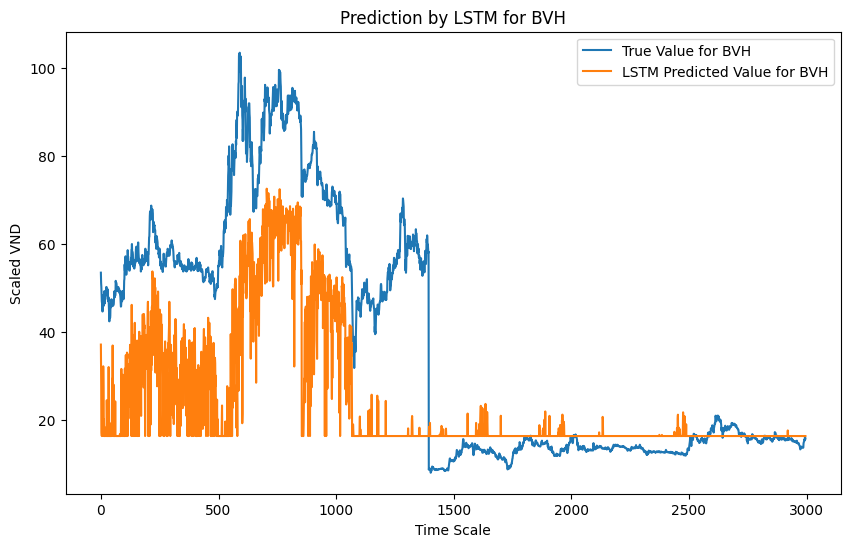

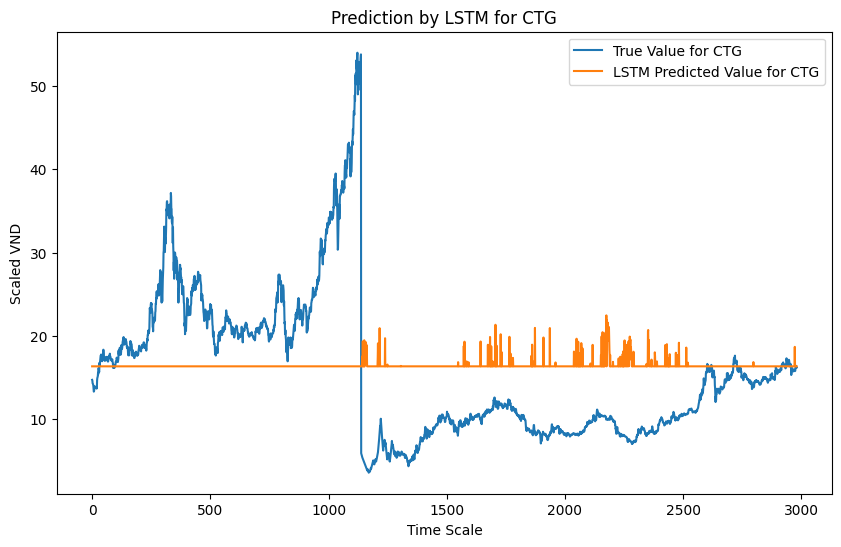

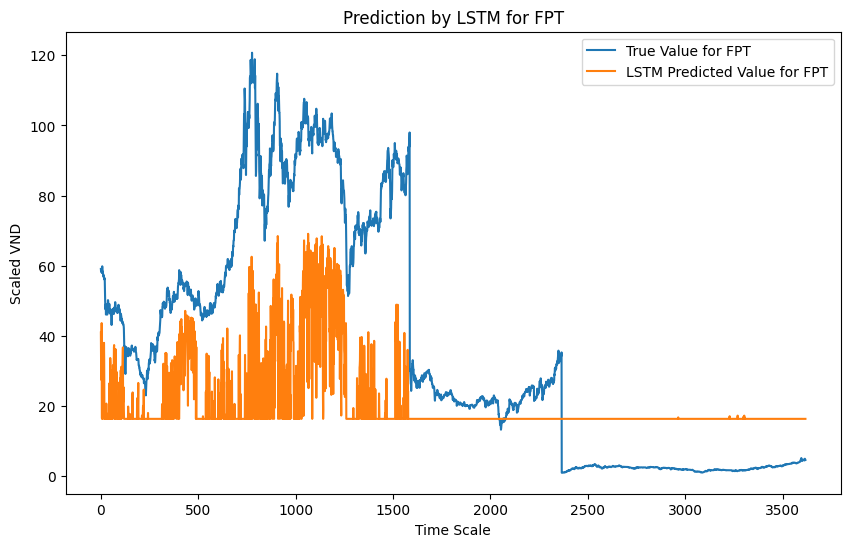

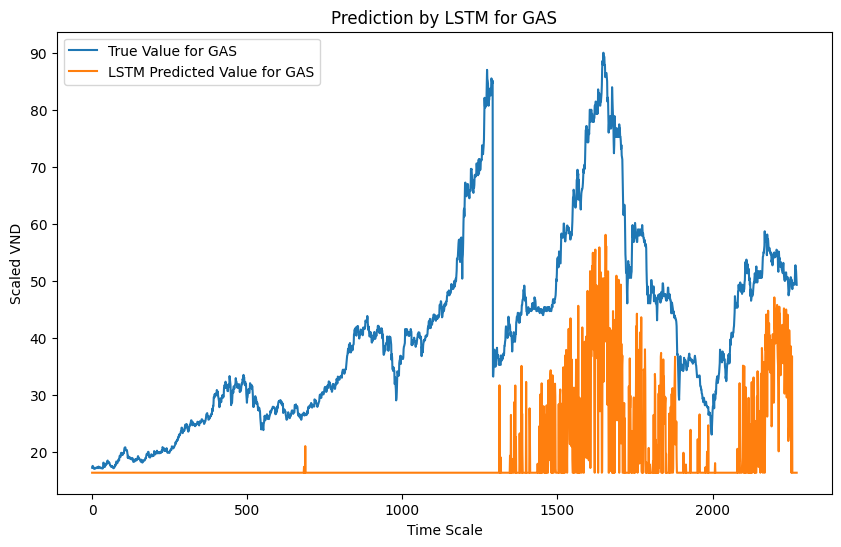

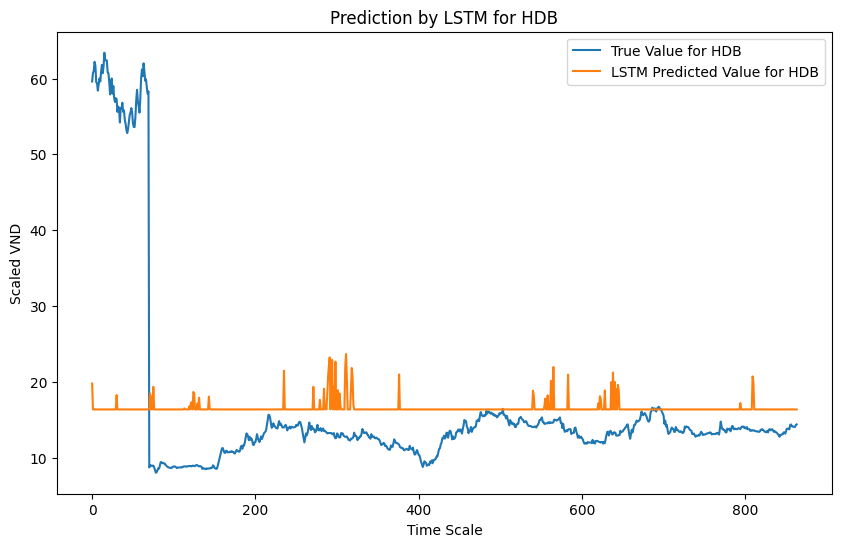

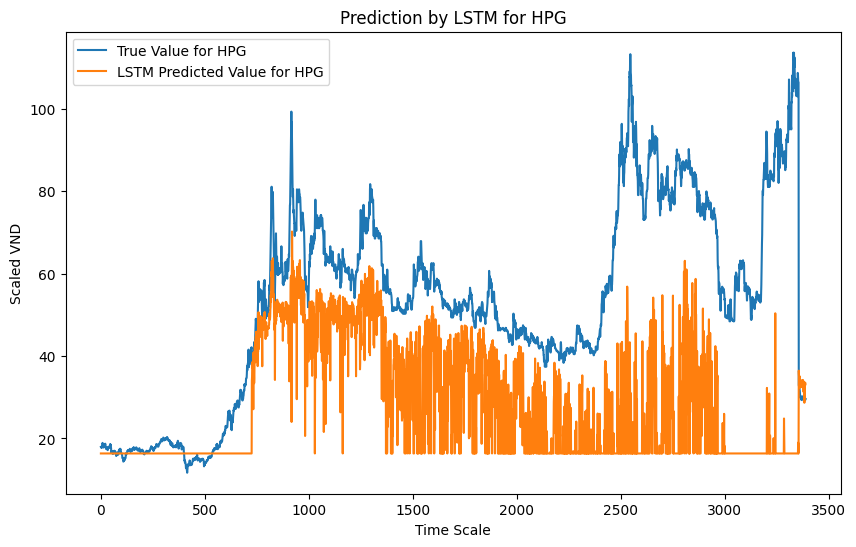

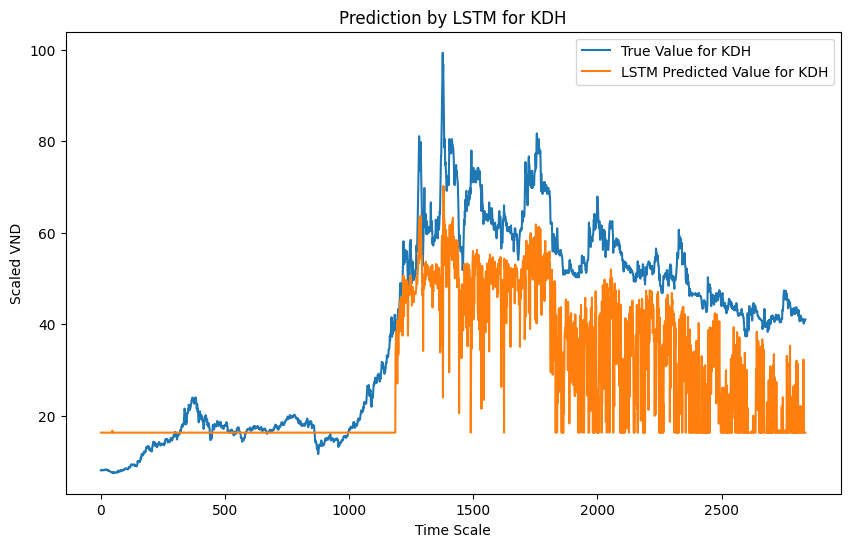

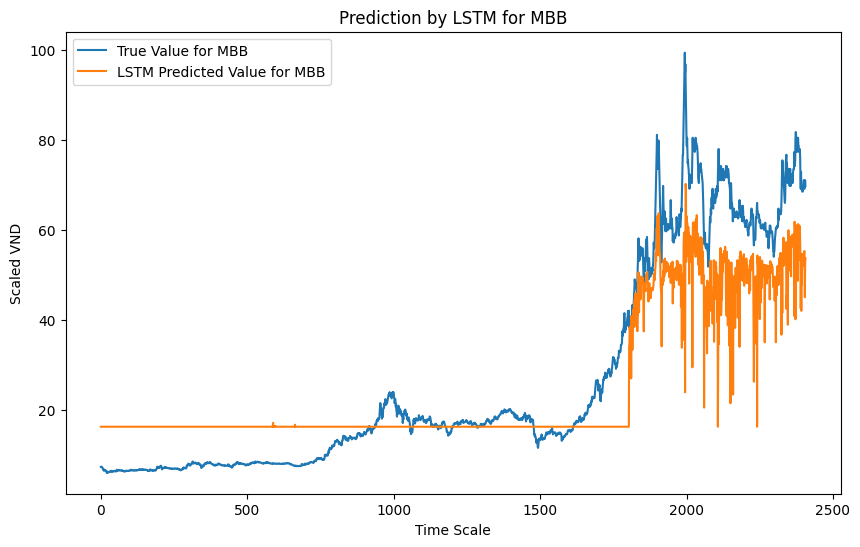

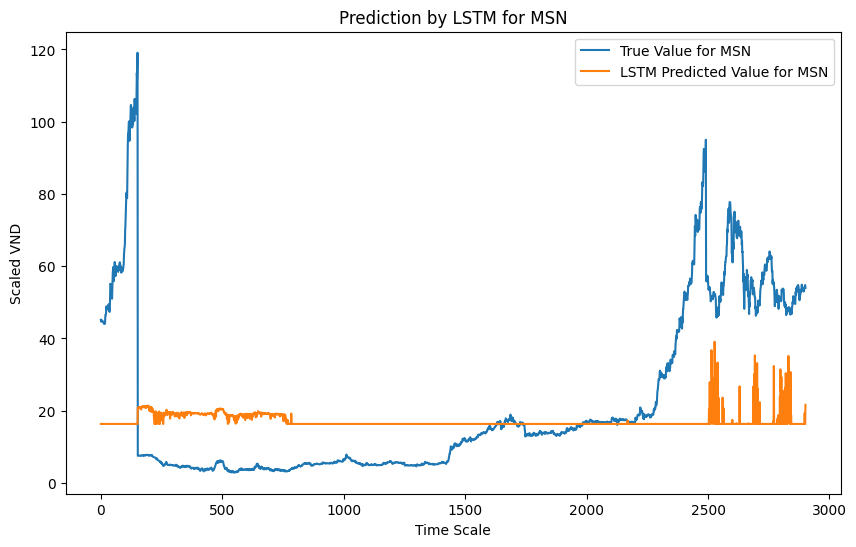

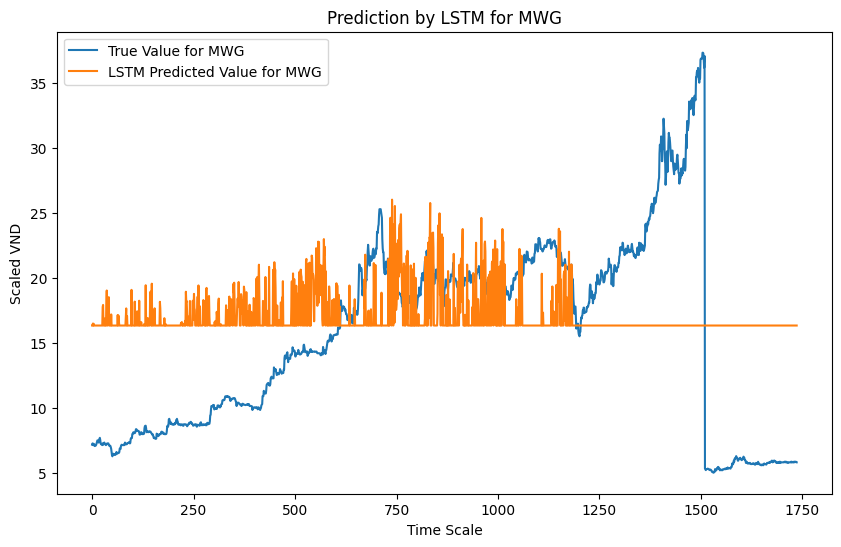

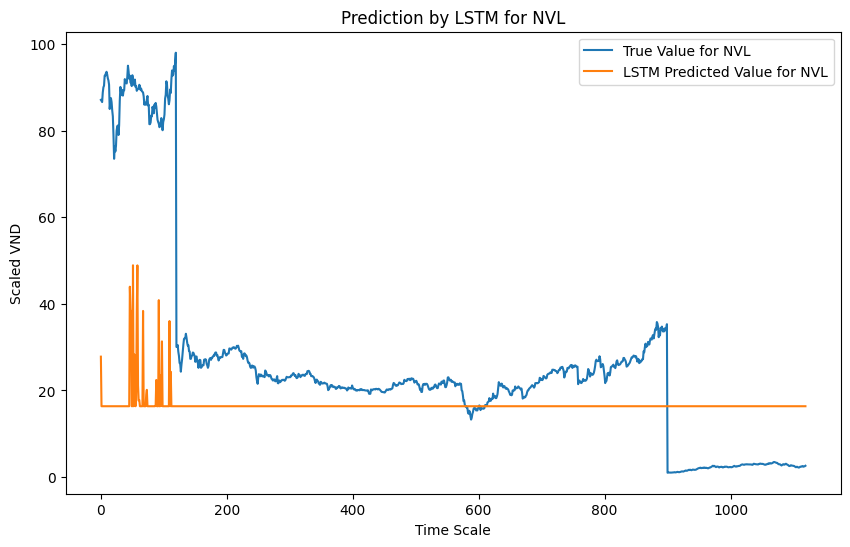

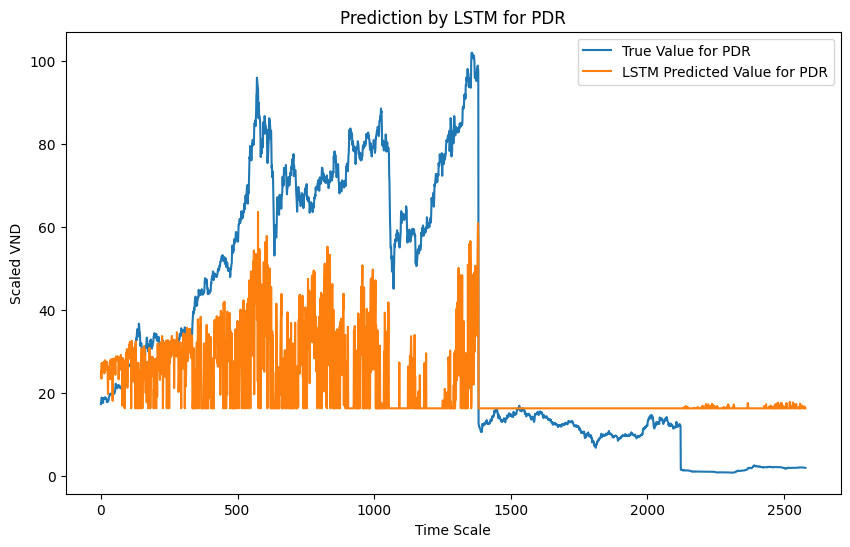

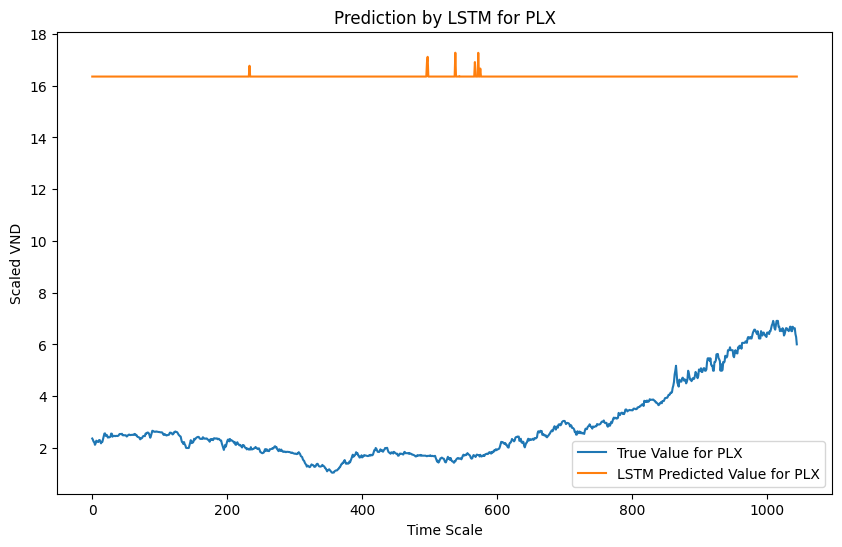

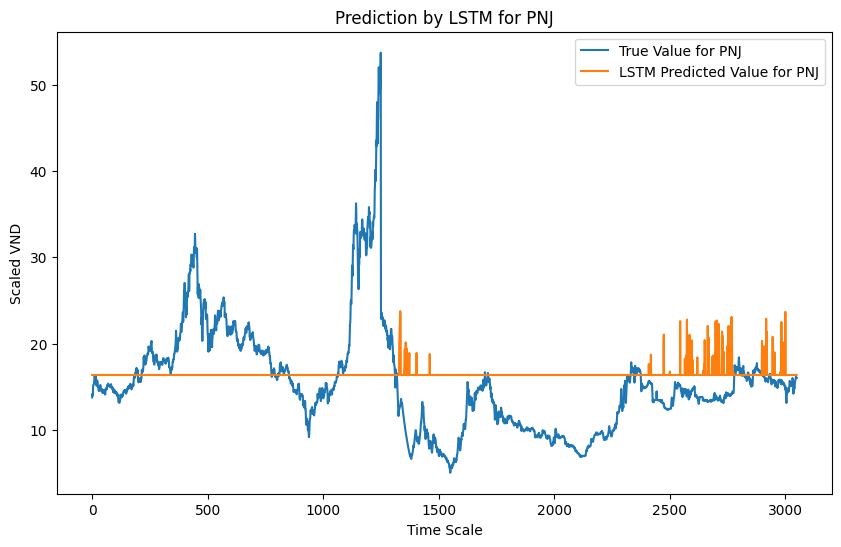

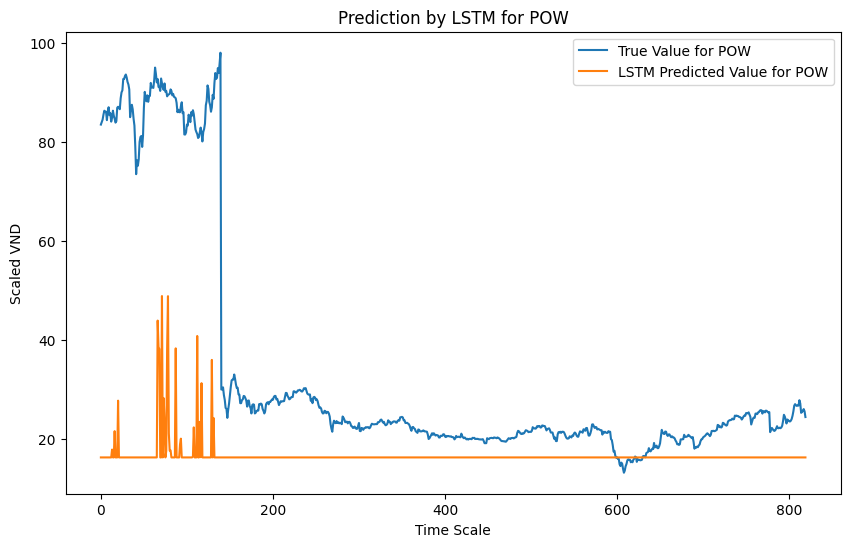

IndexError: index 80896 is out of bounds for axis 0 with size 62490

In [47]:
# Store the indices for each ticker to correctly extract the subset of y_test and y_pred
ticker_indices = {ticker: [] for ticker in df['Ticker'].unique()}

# Create a map of indices for each ticker
for idx, (ticker, group) in enumerate(grouped):
    ticker_indices[ticker].extend(range(idx * len(group), (idx + 1) * len(group)))

# LSTM Prediction
y_pred_all = lstm.predict(X_test_all)

# Plot Predicted vs True for each ticker
for ticker, indices in ticker_indices.items():
    # Extract the true and predicted values for the current ticker using the correct indices
    y_test_ticker = y_test_all[indices]
    y_pred_ticker = y_pred_all[indices]

    # Plot the true and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_ticker, label=f'True Value for {ticker}')
    plt.plot(y_pred_ticker, label=f'LSTM Predicted Value for {ticker}')
    plt.title(f"Prediction by LSTM for {ticker}")
    plt.xlabel('Time Scale')
    plt.ylabel('Scaled VND')
    plt.legend()
    plt.show()
